in conda environment for zipline3.5, `pip install pyfolio`

Pyfolio is a good entry gateway for backtest analysis, before writing anything custom.
- [pyfolio slides](https://nbviewer.jupyter.org/format/slides/github/quantopian/pyfolio/blob/master/pyfolio/examples/pyfolio_talk_slides.ipynb)

libraries
- https://www.zipline.io/appendix.html#algorithm-api
- https://github.com/newvem/pytz
- https://github.com/quantopian/pyfolio

In [1]:
from zipline import run_algorithm
from zipline.api import order_target_percent, record, symbol, schedule_function, date_rules, time_rules
from datetime import datetime
import pytz

import pyfolio as pf

/home/mkwon/anaconda3/envs/zip35/lib/python3.5/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


NOTE:

`context` is a persistent namespace for you to store variables you need to access from one algorithm iteration to the next.

In [2]:
def initialize(context):
    # Which stocks to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    """
    NOTE:
    `context` is a persistent namespace for you to store variables 
    you need to access from one algorithm iteration to the next. (Global vars work too.)
    """
    
    # make a list of symbols from tickers
    context.universe = [symbol(s) for s in dji]
    
    # history window
    context.history_window = 28
    
    # size of portfolio
    context.stocks_to_hold = 10
    
    # schedule the daily trading routine once per month. See below for API links.
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())

`schedule_function`
- https://www.zipline.io/appendix.html?highlight=schedule_function#zipline.api.schedule_function

`date_rules`
- https://www.zipline.io/appendix.html?highlight=date_rules#zipline.api.date_rules

`time_rules`
- https://www.zipline.io/appendix.html?highlight=date_rules#zipline.api.time_rules

In [3]:
def month_perf(ts):
    """
    Calculate the percentage return b/w the first and last data point
    
    Parameters: 
    ts (Series): history of stocks 
  
    Returns: 
    Series: Description of return value
    """
    perf = (ts[-1] / ts[0]) - 1
    return perf

In [10]:
def handle_data(context, data):
    
    # get history of all stocks
    hist = data.history(context.universe, "close", context.history_window, "1d")
    
    # create table of percent returns, in order
    perf_table = hist.apply(month_perf).sort_values(ascending=False)
    
    # make buy list of top N stocks, the rest will not be held
    buy_list = perf_table[:context.stocks_to_hold]
    the_rest = perf_table[context.stocks_to_hold:]
    
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold
        
        # place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)
            
    # make sure we're flat the rest
    for stock, perf in the_rest.iteritems():
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)

`order_target_percent`
- https://www.zipline.io/appendix.html?highlight=order_target#zipline.api.order_target_percent

In [11]:
def analyze(context, perf):
    
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    """
    Generate a number of plots for analyzing a strategy's returns.
    Fetches benchmarks, then creates the plots on a single figure.

    Plots: 
        rolling returns (with cone), 
        rolling beta, 
        rolling sharpe, 
        rolling Fama-French risk factors, 
        drawdowns, 
        underwater plot, 
        monthly and annual return plots, 
        daily similarity plots, and 
        return quantile box plot.

    Will also print the start and end dates of the strategy, 
    performance statistics, drawdown periods, and the return range.
    """
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

pyfolio `extract_rets_pos_txn_from_zipline`
- https://quantopian.github.io/pyfolio/notebooks/zipline_algo_example/
- https://github.com/quantopian/pyfolio/blob/master/pyfolio/utils.py

pyfolio `create_returns_tear_sheet`
- https://www.quantopian.com/docs/api-reference/pyfolio-api-reference#pyfolio.create_returns_tear_sheet

In [ ]:
# def extract_rets_pos_txn_from_zipline(backtest):
    """
    Extract returns, positions, transactions and leverage from the
    backtest data structure returned by zipline.TradingAlgorithm.run().
    The returned data structures are in a format compatible with the
    rest of pyfolio and can be directly passed to
    e.g. tears.create_full_tear_sheet().
    
    Parameters
    ----------
    backtest : pd.DataFrame
        DataFrame returned by zipline.TradingAlgorithm.run()
    
    Returns
    -------
    returns : pd.Series
        Daily returns of strategy.
         - See full explanation in tears.create_full_tear_sheet.
    
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
         - See full explanation in tears.create_full_tear_sheet.
    """
    # this is from pyfolil.utils source at https://github.com/quantopian/pyfolio/blob/master/pyfolio/utils.py

Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,11.1%
Cumulative returns,384.9%
Annual volatility,18.4%
Sharpe ratio,0.66
Calmar ratio,0.20
Stability,0.86
Max drawdown,-57.0%


/home/mkwon/anaconda3/envs/zip35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,56.97,2007-10-31,2009-03-09,2012-03-13,1140
1,13.44,2015-03-02,2015-08-25,2015-10-23,170
2,10.70,2004-04-05,2004-08-06,2004-10-18,141
3,9.75,2007-07-19,2007-08-16,2007-10-01,53
4,9.22,2003-01-06,2003-02-13,2003-03-21,55


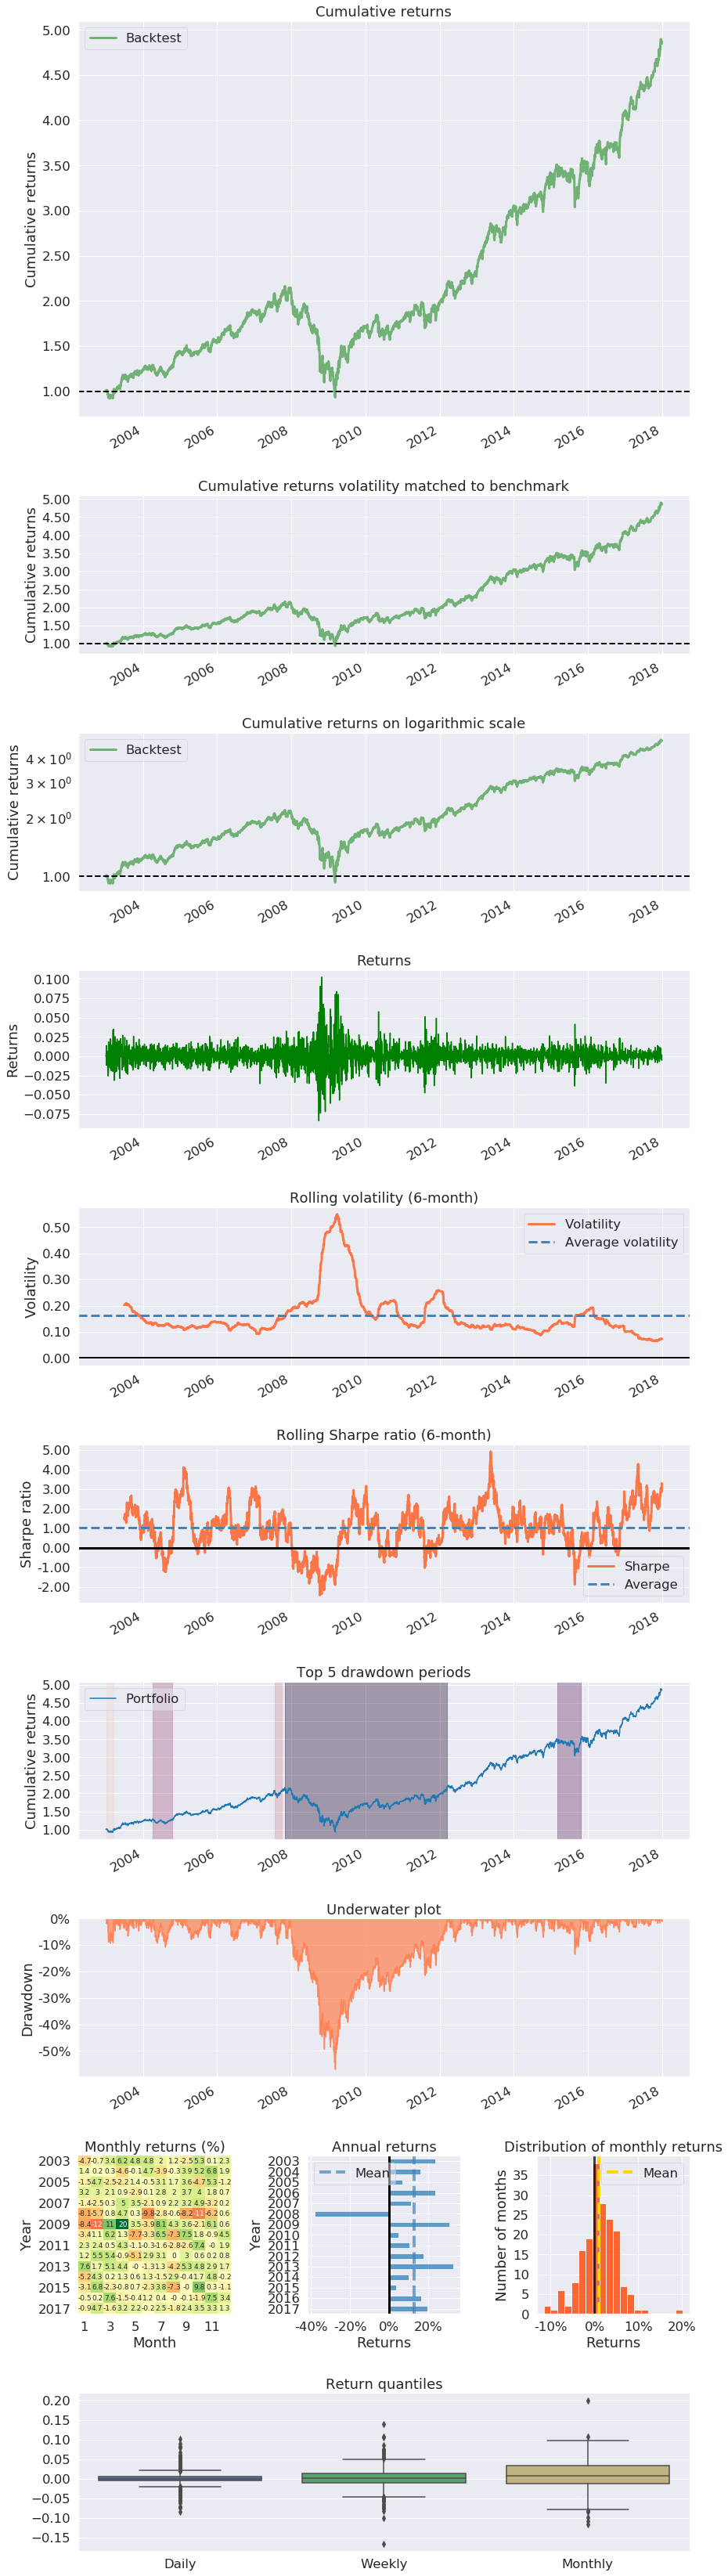

In [12]:
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2017, 12, 31, tzinfo=pytz.UTC)

# fire off backtest
result = run_algorithm(start=start, 
                       end=end,
                       initialize=initialize,
                       analyze=analyze,
                       capital_base=10000,
                       data_frequency='daily',
                       bundle='quandl')

In [13]:
%%html
<style>
table {float:left}
</style>

Backtest | Results 
--- | --- 
Annual return|	11.1%
Cumulative returns|	384.9%
Annual volatility|	18.4%
Sharpe ratio|	0.66
Calmar ratio|	0.20
Stability|	0.86
Max drawdown|	-57.0%
Omega ratio|	1.13
Sortino ratio|	0.97
Skew|	0.22
Kurtosis|	9.23
Tail ratio|	0.98
Daily value at risk|	-2.3%

### Basic definitions:
- [annual return](https://www.investopedia.com/terms/a/annual-return.asp)
    - annual return calculation: **Compound Annual Growth Rate (CAGR)** <img src="https://www.investopedia.com/thmb/kgDBS7O_zcx6Sv2YLOsIpnNaWwU=/305x0/filters:no_upscale():max_bytes(150000):strip_icc()/CAGRFormula1-5bfd70a346e0fb0026966763"/>
    - An annual or annualized return is a measure of how much an investment has increased on average each year, during a specific time period.
    - The annualized return is calculated as a geometric average to show what the annual return compounded would look like.
    - An annual return can be more useful than a simple return when you want to see how an investment has performed over time, or to compare two investments.
    - An annual return can be determined for a variety of assets, including stocks, bonds, mutual funds, ETFs, commodities, and certain derivatives.
    
- [cumulative return](https://www.investopedia.com/terms/c/cumulativereturn.asp)
    -  \begin{equation*}
    \frac{(Current Price of Security) − (Original Price of Security)}{Original Price of Security}
    \end{equation*}
    - Expressed as a percentage, cumulative return on an investment is the aggregate amount that the investment has gained or lost over time, independent of the period of time involved.
    - Reinvesting the dividends or capital gains of an investment impacts its cumulative return.
    - Cumulative return figures for mutual typically omit the effect of annual expense ratios and other fees on the fund's performance.

- [volatility](https://www.investopedia.com/terms/v/volatility.asp)
    - Volatility is a statistical measure of the dispersion of returns for a given security or market index. In most cases, the higher the volatility, the riskier the security.
    - There are many different ways to measure volatility, including beta coefficients, option pricing, and standard deviations.
    - More volatile assets are considered riskier than less volatile assets because the price is expected to be less predictable.
- [maximum drawdown](https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp)
    -  \begin{equation*}
    MDD = \frac{(Trough Value) − (Peak Value)}{Peak Value}
    \end{equation*}
    - Maximum drawdown (MDD) is a measure of an asset's largest price drop from a peak to a trough.
    - Maximum drawdown is considered to be an indicator of downside risk, with large MDDs suggesting that down movements could be volatile.
    - While MDD measures the largest loss, it does not account for the frequency of losses, not the size of any gains.
- [Calmar ratio](https://www.investopedia.com/terms/c/calmarratio.asp)
    - The Calmar ratio is a comparison of the average annual compounded [rate of return](https://www.investopedia.com/terms/r/rateofreturn.asp) and the maximum drawdown risk of [commodity trading advisors](https://www.investopedia.com/terms/c/cta.asp) and [hedge funds](https://www.investopedia.com/terms/h/hedgefund.asp). 
    - The lower the Calmar ratio, the worse the investment performed on a risk-adjusted basis over the specified time period; the higher the Calmar ratio, the better it performed. Generally speaking, the time period used is three years, but this can be higher or lower based on the investment in question.

- [Sharpe ratio](https://www.investopedia.com/terms/s/sharperatio.asp)
    - \begin{equation*}
    Sharpe Ratio = \frac{(Return Of Portfolio) − (Risk Free Rate)}{Standard Deviation Of Portfolio's Excess Return}
    \end{equation*}
    - the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    - The Sharpe ratio adjusts a portfolio’s past performance—or expected future performance—for the excess risk that was taken by the investor.
    - A high Sharpe ratio is good when compared to similar portfolios or funds with lower returns.
    - The Sharpe ratio has several weaknesses including an assumption that investment returns are normally distributed.
- [Sortino ratio](https://www.investopedia.com/terms/s/sortinoratio.asp)
    - \begin{equation*}
    Sortino Ratio = \frac{(Return Of Portfolio) − (Risk Free Rate)}{Standard Deviation Of The Downside}
    \end{equation*}
    - The Sortino ratio differs from the Sharpe ratio in that it only considers the standard deviation of the downside risk, rather than that of the entire (upside + downside) risk.
    - Because the Sortino ratio focuses only on the negative deviation of a portfolio's returns from the mean, it is thought to give a better view of a portfolio's risk-adjusted performance since positive volatility is a benefit.
  - - [Sharpe vs Sortino](https://www.investopedia.com/ask/answers/010815/what-difference-between-sharpe-ratio-and-sortino-ratio.asp)
  
- [skewness](https://www.investopedia.com/terms/s/skewness.asp)
    - Investors note skewness when judging a return distribution because it, like kurtosis, considers the extremes of the data set rather than focusing solely on the average. Short- and medium-term investors in particular need to look at extremes because they are less likely to hold a position long enough to be confident that the average will work itself out.
    - Investors commonly use standard deviation to predict future returns, but standard deviation assumes a normal distribution. As few return distributions come close to normal, skewness is a better measure on which to base performance predictions. This is due to skewness risk.
    - Skewness risk is the increased risk of turning up a data point of high skewness in a skewed distribution. Many financial models that attempt to predict the future performance of an asset assume a normal distribution, in which measures of central tendency are equal. If the data are skewed, this kind of model will always underestimate skewness risk in its predictions. The more skewed the data, the less accurate this financial model will be.
- [kurtosis](https://www.investopedia.com/terms/k/kurtosis.asp)
    - Whereas skewness differentiates extreme values in one versus the other tail, kurtosis measures extreme values in either tail. Distributions with large kurtosis exhibit tail data exceeding the tails of the normal distribution (e.g., five or more standard deviations from the mean). Distributions with low kurtosis exhibit tail data that are generally less extreme than the tails of the normal distribution.
    - For investors, high kurtosis of the return distribution implies that the investor will experience occasional extreme returns (either positive or negative), more extreme than the usual + or - three standard deviations from the mean that is predicted by the normal distribution of returns. This phenomenon is known as kurtosis risk.

### General rules of thumb:
- unlikely to compound over 15% per year over any longer period of time
- unlikely to achieve Sharpe Ratio over 1
- probably see a maximum drawdown of 3x your long term annualized return

In [15]:
# result is just a dataframe
result.loc['2010-11-17']

algo_volatility                                                     0.218678
algorithm_period_return                                             0.708461
alpha                                                                   None
benchmark_period_return                                                    0
benchmark_volatility                                                       0
beta                                                                    None
capital_used                                                               0
ending_cash                                                          416.342
ending_exposure                                                      16668.3
ending_value                                                         16668.3
excess_return                                                              0
gross_leverage                                                      0.975631
long_exposure                                                        16668.3

### Day Snapshot

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# get portfolio value and positions for a specified day
DAY = '2009-03-17'
portfolio_value = result.loc[DAY, 'portfolio_value']
day_positions = result.loc[DAY, 'positions']

In [22]:
print(portfolio_value)
for pos in day_positions:
    print(pos)

11105.066062499996
{'sid': Equity(1441 [IBM]), 'amount': 12, 'cost_basis': 86.86464809523811, 'last_sale_price': 92.91}
{'sid': Equity(1264 [GS]), 'amount': 12, 'cost_basis': 88.82564, 'last_sale_price': 98.99000000000001}
{'sid': Equity(8 [AAPL]), 'amount': 12, 'cost_basis': 93.02757333333334, 'last_sale_price': 99.66}
{'sid': Equity(705 [CSCO]), 'amount': 70, 'cost_basis': 14.398195, 'last_sale_price': 16.14}
{'sid': Equity(3105 [WMT]), 'amount': 20, 'cost_basis': 47.40469, 'last_sale_price': 50.0}
{'sid': Equity(1615 [KO]), 'amount': 25, 'cost_basis': 38.850415, 'last_sale_price': 41.45}
{'sid': Equity(1496 [INTC]), 'amount': 81, 'cost_basis': 12.28714, 'last_sale_price': 14.9}
{'sid': Equity(2979 [V]), 'amount': 18, 'cost_basis': 54.388180000000006, 'last_sale_price': 55.29}
{'sid': Equity(1576 [JPM]), 'amount': 47, 'cost_basis': 21.021505, 'last_sale_price': 25.14}
{'sid': Equity(1321 [HD]), 'amount': 50, 'cost_basis': 18.900445, 'last_sale_price': 21.48}


In [26]:
# populate position info: the value, and the open profit and loss
df = pd.DataFrame(columns=['value', 'pnl'])
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker, 'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker, 'pnl'] = df.loc[ticker, 'value'] - (pos['amount'] * pos['cost_basis'])
    
# add cash position, which would be the total portfolio value minux value of stocks we hold
df.loc['cash', ['value', 'pnl']] = [(portfolio_value - df['value'].sum()), 0]

print(df.head(11))

        value      pnl
IBM   1114.92  72.5442
GS    1187.88  121.972
AAPL  1195.92  79.5891
CSCO   1129.8  121.926
WMT      1000  51.9062
KO    1036.25  64.9896
INTC   1206.9  211.642
V      995.22  16.2328
JPM   1181.58  193.569
HD       1074  128.978
cash -17.4039        0


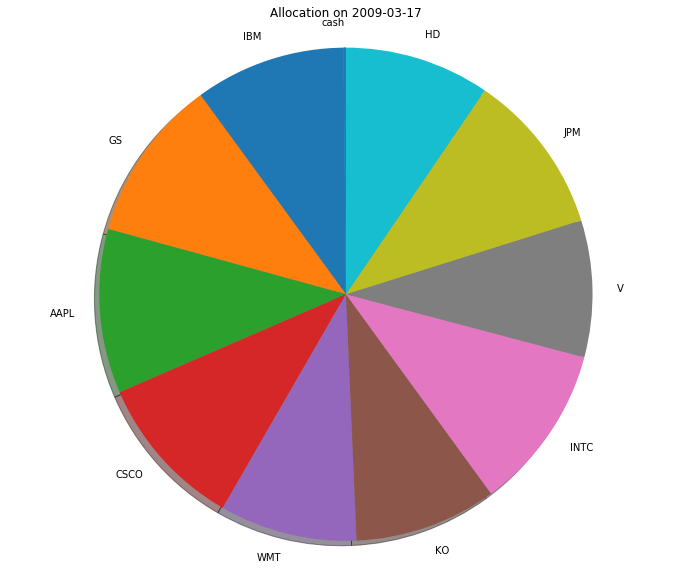

In [28]:
# pie chart for allocations
fix, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(DAY))
plt.show()

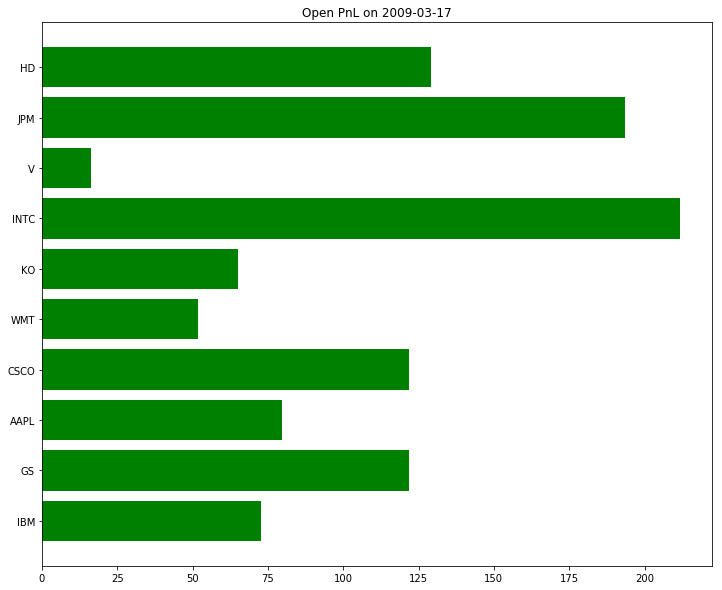

In [31]:
# bar chart for open PnL (Open profit and loss per position)
# NOTE: this result is different from book chart.. check data
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh( pnl_df.index, pnl_df['pnl'], align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(DAY))
plt.show()

### Custom time series analysis-- going to plot four things:
1. semi-log graph of equity curve itself
2. the exposure held over time
3. half a year rolling returns, on an annualized basis (needs to be calculated)
    - \begin{equation*}
    AnnualizedReturn = \left(\frac{EndValue}{StartValue}\right)^\frac{YearDays}{ActualDays} -1
    \end{equation*}
4. maximum drawdown on a time window (needs to be calculated)
    - MDD: largest peak-to-trough decline in the value of a portfolio (before a new peak is achieved)
    - \begin{equation*}
    \end{equation*}

In [43]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, rc, ticker

# Settings
CALC_WINDOW = 126
YEAR_LENGTH = 252

In [44]:
def annualized_return(ts):
    return np.power((ts[-1] / ts[0]), (YEAR_LENGTH/len(ts))) - 1  

def drawdown(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

In [45]:
# Copy the columns we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

df.head()

,portfolio_value,gross_leverage
2003-01-02 00:00:00+00:00,10000.000000,0.000000
2003-01-03 00:00:00+00:00,9994.892601,0.973377
2003-01-06 00:00:00+00:00,10128.955601,0.973729
2003-01-07 00:00:00+00:00,10009.175601,0.973415
2003-01-08 00:00:00+00:00,9945.905601,0.973246


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

In [46]:
# Get a rolling window
rolling_window = result.portfolio_value.rolling(CALC_WINDOW)

print(rolling_window)

Rolling [window=126,center=False,axis=0]


In [47]:
# Calculate rolling analytics
df['annualized'] = rolling_window.apply(annualized_return)
df['drawdown'] = rolling_window.apply(drawdown)

In [48]:
df.head()

,portfolio_value,gross_leverage,annualized,drawdown
2003-01-02 00:00:00+00:00,10000.000000,0.000000,NaN,NaN
2003-01-03 00:00:00+00:00,9994.892601,0.973377,NaN,NaN
2003-01-06 00:00:00+00:00,10128.955601,0.973729,NaN,NaN
2003-01-07 00:00:00+00:00,10009.175601,0.973415,NaN,NaN
2003-01-08 00:00:00+00:00,9945.905601,0.973246,NaN,NaN


In [49]:
# Drop initial n/a values
df.dropna(inplace=True)

In [50]:
df.head()

,portfolio_value,gross_leverage,annualized,drawdown
2003-07-02 00:00:00+00:00,11589.747784,0.996413,0.343223,-0.092241
2003-07-03 00:00:00+00:00,11471.967784,0.996377,0.317406,-0.092241
2003-07-07 00:00:00+00:00,11750.804783,0.996463,0.345879,-0.092241
2003-07-08 00:00:00+00:00,11789.507784,0.996474,0.387378,-0.088957
2003-07-09 00:00:00+00:00,11815.887784,0.996482,0.411380,-0.088957


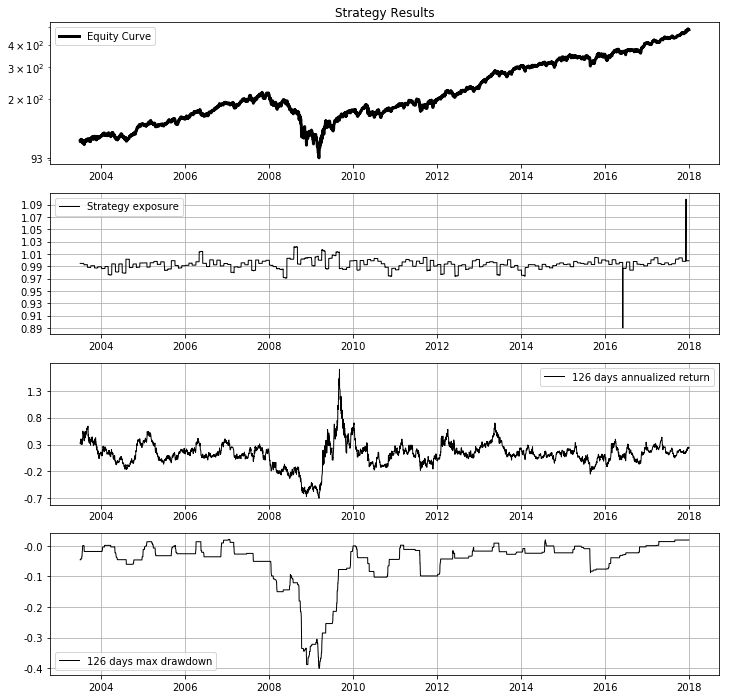

In [51]:
# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(CALC_WINDOW), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(CALC_WINDOW), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(CALC_WINDOW), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)